In [1]:
import scipy as scp
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
from amplpy import AMPL, add_to_path                                   
add_to_path(r"/home/nikita/Projects/INF580/ampl") 

from graph_utils import *
from tutte_embedding import *
from DGP_utils import *

In [2]:
#store graph as a matrix
n=7
G = np.array([[0,1,1,1,0,1,1],
              [1,0,1,1,1,0,1],
              [1,1,0,0,1,1,1],
              [1,1,0,0,0,0,1],
              [0,1,1,0,0,0,1],
              [1,0,1,0,0,0,1],
              [1,1,1,1,1,1,0]])

In [3]:
G_list = matrix_to_list(G) #transform graph to adjacency list represetnation

In [4]:
poly = [(0,np.array([-1,0])),(1,np.array([0,1])),(2,np.array([1,0]))] #fix outer face coordinates

In [5]:
XY=Tutte_Embedding(G_list,poly) #calculate Tutte embedding

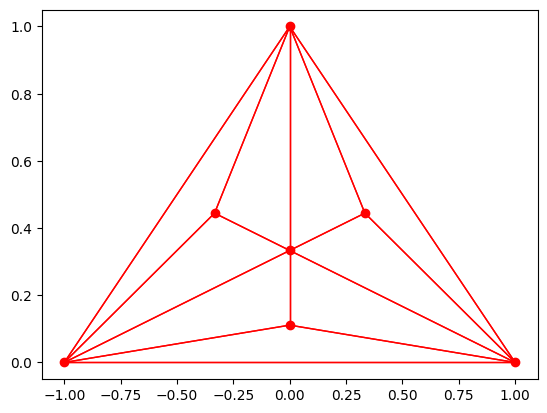

In [6]:
draw_graph(XY,G_list) #draw embedding

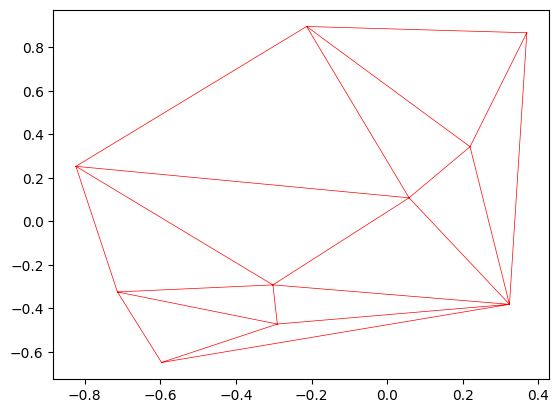

In [17]:
#triangulate random points
N=10
points = generate_random_points(N)
triangulation = scp.spatial.Delaunay(points)
draw_triangulation(triangulation.points,triangulation.simplices,draw_points=False,edge_width=0.5)
plt.savefig("trian{N}.pdf".format(N=N))

In [18]:
#transform triangulation to adjacency list represented graph
G_list = triangulation_to_graph(N,triangulation.simplices)

In [19]:
#fixe coordianates of a face on a convex polygon 

poly = randomFace_of_triangulation(triangulation)
#poly, three_connected = boundary_of_triangulation(triangulation)

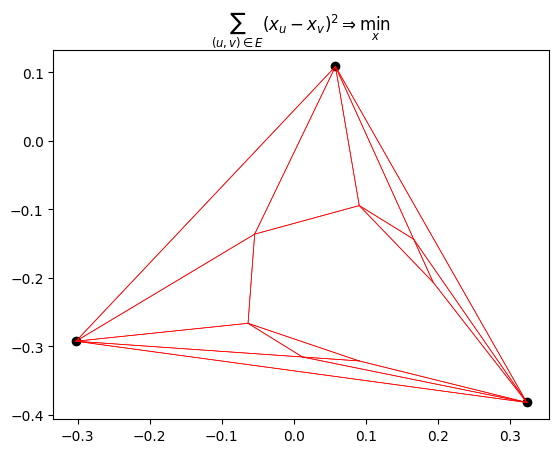

In [20]:
#calculate spring energy minimization embedding
indices=np.hstack(([i for i,p in poly],[i+N for i,p in poly]))
coordinates=np.hstack(([p[0] for i,p in poly],[p[1] for i,p in poly]))
fixed_points=(indices,coordinates) 
XY = solve_energy_minimization(G_list,fixed_points)
XY=np.transpose(np.vstack((XY[:N],XY[N:])))
draw_graph(XY,G_list,draw_points=False,edge_width=0.5)
plt.scatter([p[0] for v,p in poly],[p[1] for v,p in poly],color='black')
plt.title('$\sum_{(u,v)\in E} (x_u-x_v)^2 \Rightarrow \min_{x}$')
plt.savefig("spring{N}.pdf".format(N=N))

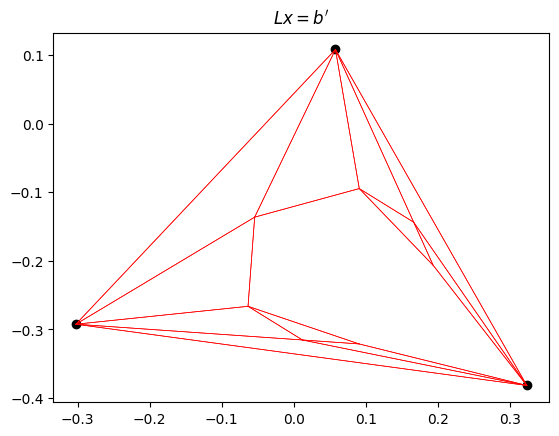

In [21]:
#calculate Tutte embedding
XY = Tutte_Embedding(G_list,poly)
draw_graph(XY,G_list,draw_points=False,edge_width=0.5)
plt.scatter([p[0] for v,p in poly],[p[1] for v,p in poly],color='black')
plt.title("$Lx=b'$")
plt.savefig("tutte{N}.pdf".format(N=N))

In [41]:
#to remove edges from graph

# Ne = count_edges(G_list)
# Ne_remove = int(Ne*1/2)
# G_list_reduced,connected=randomly_remove_edges(Ne_remove,G_list)
# print(connected)
# G_list=G_list_reduced

CONOPT 3.17A: Locally optimal; objective 4.073215426e-18
10 iterations; evals: nf = 10, ng = 8, nc = 0, nJ = 0, nH = 2, nHv = 16


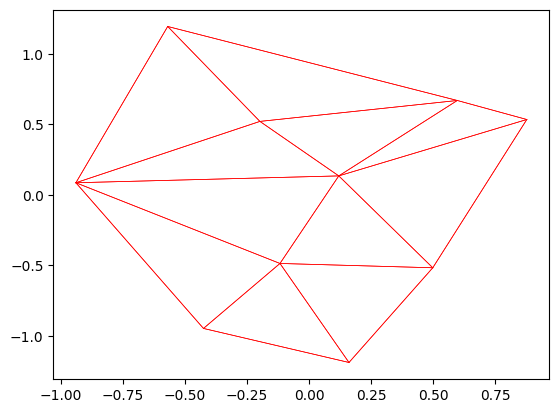

In [12]:
#PCA + FW reconstruction
D = graph_to_distances(XY,G_list)
shortestPaths_matrix = scp.sparse.csgraph.floyd_warshall(D, directed=False)
gram_matrix=dist2Gram(shortestPaths_matrix)
X_PCA_FW=PCA(gram_matrix)
X_PCA_FW = solve_DGP_locally(D,G_list,X_PCA_FW)
draw_graph(X_PCA_FW,G_list,draw_points=False,edge_width=0.5)

                                     CVXPY                                     
                                     v1.3.0                                    
(CVXPY) Mar 13 04:47:09 PM: Your problem has 100 variables, 20 constraints, and 0 parameters.
(CVXPY) Mar 13 04:47:09 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Mar 13 04:47:09 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Mar 13 04:47:09 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Mar 13 04:47:09 PM: Compiling problem (target solver=SCS).
(CVXPY) Mar 13 04:47:09 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -

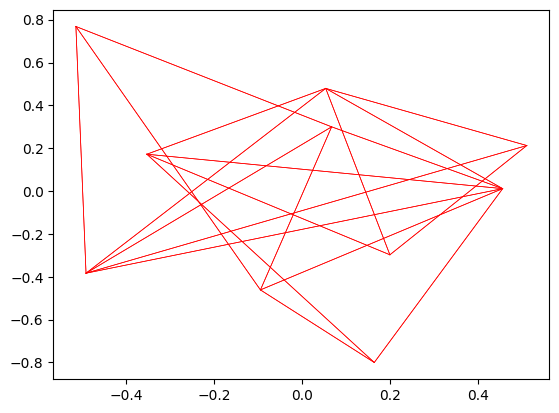

In [13]:
#PCA + SDP reconstruction
gram_matrix=solve_SDP(D,G_list)
X_PCA_SDP = PCA(gram_matrix)
X_PCA_SDP = solve_DGP_locally(D,G_list,X_PCA_SDP)
draw_graph(X_PCA_SDP,G_list,draw_points=False,edge_width=0.5)

In [7]:
import time
import json
import os

In [28]:
#run experiment
def evaluate(dir_name, alpha=None):
    
    if(os.path.isdir(dir_name)):
        raise Exception('directory {dir_name} already exists'.format(dir_name=dir_name))
    os.mkdir(dir_name)
    
    Ns=np.linspace(10,2e2,10,dtype='int64') #number of vertices of the graph
    MDE_loss={'PCA_FW':[],'PCA_FW_local':[],'PCA_SDP':[],'PCA_SDP_local':[]}
    LDE_loss={'PCA_FW':[],'PCA_FW_local':[],'PCA_SDP':[],'PCA_SDP_local':[]}
    run_time={'PCA_FW':[],'PCA_FW_local':[],'PCA_SDP':[],'PCA_SDP_local':[]}
    
    for N in Ns:
        #generate planar graph with Tutte embedding
        points=generate_random_points(N)
        triangulation = scp.spatial.Delaunay(points)
        G_list = triangulation_to_graph(N,triangulation.simplices)
        poly, three_connected = boundary_of_triangulation(triangulation)
        if(three_connected==False):
            print(N,"not 3-connected graph")
        X_true=Tutte_Embedding(G_list,poly)
        
        #remove some edges if needed
        if(alpha != None): #n_edges/n_vertices ratio
            N_edges=count_edges(G_list)
            N_edges2remove=N_edges-int(alpha*N)
            connected=False
            while(connected==False):
                G_list_reduced,connected=randomly_remove_edges(N_edges2remove,G_list)
            G_list=G_list_reduced
                
        
        D = graph_to_distances(X_true,G_list)
        
        t1=time.time()
        shortestPaths_matrix = scp.sparse.csgraph.floyd_warshall(D, directed=False)
        gram_matrix=dist2Gram(shortestPaths_matrix)
        X_PCA_FW=PCA(gram_matrix)
        t2=time.time()
        X_PCA_FW_local=solve_DGP_locally(D,G_list,X_PCA_FW)
        t3=time.time()
        
        t4=time.time()
        gram_matrix=solve_SDP(D,G_list)
        X_PCA_SDP = PCA(gram_matrix)
        t5=time.time()
        X_PCA_SDP_local = solve_DGP_locally(D,G_list,X_PCA_SDP)
        t6=time.time()
        
        MDE_loss['PCA_FW'].append(MDE(X_PCA_FW,D,G_list))
        LDE_loss['PCA_FW'].append(LDE(X_PCA_FW,D,G_list))
        run_time['PCA_FW'].append(t2-t1)
        
        MDE_loss['PCA_FW_local'].append(MDE(X_PCA_FW_local,D,G_list))
        LDE_loss['PCA_FW_local'].append(LDE(X_PCA_FW_local,D,G_list))
        run_time['PCA_FW_local'].append(t3-t1)
        
        MDE_loss['PCA_SDP'].append(MDE(X_PCA_SDP,D,G_list))
        LDE_loss['PCA_SDP'].append(LDE(X_PCA_SDP,D,G_list))
        run_time['PCA_SDP'].append(t5-t4)
        
        MDE_loss['PCA_SDP_local'].append(MDE(X_PCA_SDP_local,D,G_list))
        LDE_loss['PCA_SDP_local'].append(LDE(X_PCA_SDP_local,D,G_list))
        run_time['PCA_SDP_local'].append(t6-t4)
    
    with open(dir_name+'/'+'MDE_loss.json', 'w') as fp:
        json.dump(MDE_loss, fp)
    with open(dir_name+'/'+'LDE_loss.json', 'w') as fp:
        json.dump(LDE_loss, fp)
    with open(dir_name+'/'+'run_time.json', 'w') as fp:
        json.dump(run_time, fp)
    with open(dir_name+'/'+'param.json', 'w') as fp:
        json.dump({'n':list(Ns.astype(float))}, fp)
        
    return

In [30]:
dir_name='alpha_15'
evaluate(dir_name,alpha=1.5)

10 not 3-connected graph
CONOPT 3.17A: Locally optimal; objective 1.138347107e-15
14 iterations; evals: nf = 19, ng = 12, nc = 0, nJ = 0, nH = 3, nHv = 32
                                     CVXPY                                     
                                     v1.3.0                                    
(CVXPY) Mar 12 02:11:48 PM: Your problem has 100 variables, 15 constraints, and 0 parameters.
(CVXPY) Mar 12 02:11:48 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Mar 12 02:11:48 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Mar 12 02:11:48 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY)

In [31]:
data={}
for file_name in os.listdir(dir_name):
    with open(dir_name+'/'+file_name, 'r') as f:
         data[file_name.split('.')[0]] = json.load(f)

In [32]:
param=data['param']['n']
LDE_loss=data['LDE_loss']
MDE_loss=data['MDE_loss']
run_time=data['run_time']

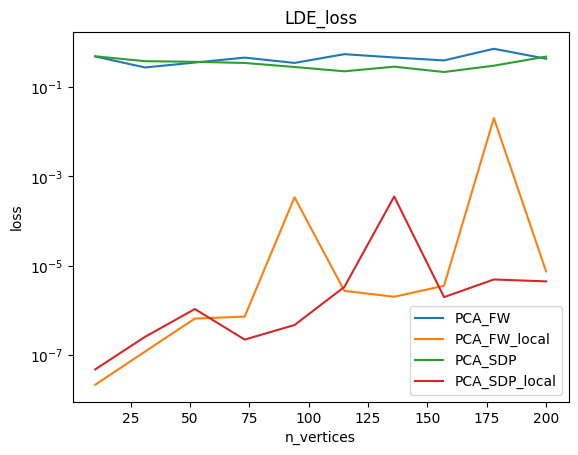

In [33]:
title='LDE_loss'
for label,loss in LDE_loss.items():
    plt.plot(param,loss,label=label)

plt.xlabel('n_vertices')
plt.ylabel('loss')
plt.yscale('log')
plt.title(title)
plt.legend()
plt.savefig(dir_name+'/'+title+'.pdf')

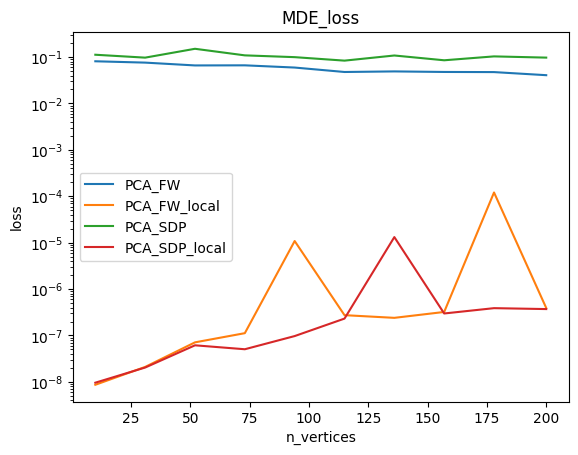

In [34]:
title='MDE_loss'
for label,loss in MDE_loss.items():
    plt.plot(param,loss,label=label)

plt.xlabel('n_vertices')
plt.ylabel('loss')
plt.yscale('log')
plt.title(title)
plt.legend()
plt.savefig(dir_name+'/'+title+'.pdf')

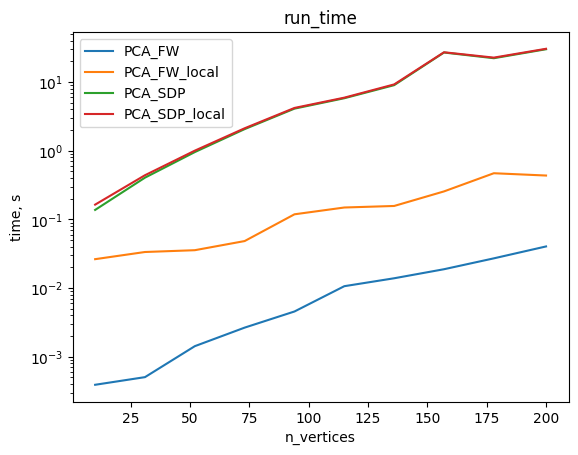

In [35]:
title='run_time'
for label,loss in run_time.items():
    plt.plot(param,loss,label=label)

plt.xlabel('n_vertices')
plt.ylabel('time, s')
plt.yscale('log')
plt.title(title)
plt.legend()
plt.savefig(dir_name+'/'+title+'.pdf')